# Neutron Imaging Sample Processing

This script takes images acquired at the NEUTRA facility and calculates the moisture absorption of the sample (front location) and calibrates the moisture content by the step wedge method.

### Samples
The samples used in this section are as follows... <br>
Sample 2 is a 75% PCBFS at 28 Days <br>
Sample 4 is a 75% PCBFS at 90 Days <br>
Sample 14 is a 90% PCBFS at 28 Days <br>
Sample 16 is a 90% PCBFS at 90 Days 

### Python Modules

We take the `time` module for time (epoch) calculations the data for which are pulled from the fits header. `scikit-image` is used for matrix (image) calculations. `scipy.optimize` provides the `curve_fit` and `leastsq` least squares regression fitting functions. `astropy.io` provides functions for reading `fits` data from the filesystem. `numpy` provides further matrix operations. `glob` provides file system manipulation functions. The remaining modules and settings are used for production of graphics by this script and visualisation.

In [1]:
import time

from skimage import data, io, filters
from scipy.optimize import curve_fit
from scipy.optimize import leastsq

import astropy.io
from astropy.io import fits
import numpy as np
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)
%matplotlib inline

pagewidth  = 6.12325
pageheight = 8.82063
goldenrat  = 1.61803
colors     = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
cmap       = 'Blues'

pixel_size = 0.1

### Notes: 

This script is designed to run on high RAM systems (> ~16 GB) where every image in raw format can be loaded to memory. <br>

Visualisations are clipped to a maxima of 27500 for the purposes of data rendering with no rescaling (all values below 27500 remain correct; those above are clipped to white). <b> All calculations are carried out on the fully unmodified dataset. </b>

In [2]:
def smooth(x):
    window_len = 50
    s = np.r_[x[window_len-1:0:-1], x, 
              x[-2:-window_len-1:-1]]
    w=eval('np.hanning(50)')
    y=np.convolve(w/w.sum(), s, mode='valid')
    return y

Pull data from the filesystem. File paths from all uptake, dark current, open beam, dry sample, black beam, wet and dry wedge images are defined from the filesystem and sorted alphanumerically.

In [3]:
files = sorted(glob.glob('WET/*.fits'))
dark  = sorted(glob.glob('DARK/*.fits'))
openb = sorted(glob.glob('OB/*.fits'))
dry   = sorted(glob.glob('DRY/*.fits'))
black = sorted(glob.glob('BB/*.fits'))

wedges_wet = sorted(
    glob.glob('Wedges/wedge_wet_sample_*.fits'))

wedges_dry = sorted(
    glob.glob('Wedges/wedge_dry_sample_*.fits'))

Load the first file and get width and height data from the header. We also take the total number of files here. Return some output to the user for debugging and good measure.

In [4]:
w = fits.open(files[0])[0].header['NAXIS2']
h = fits.open(files[0])[0].header['NAXIS1']
nfiles = len(files)
ndark  = len(dark)
nopenb = len(openb)
ndry   = len(dry)
nblack = len(black)
print('Width: ' + str(w) + ', ' + 'Height: ' + str(h))
print('Count: ' + str(nfiles))
print('Dark:  ' + str(ndark))
print('Open:  ' + str(nopenb))
print('Dry:   ' + str(ndry))
print('Black  ' + str(nblack))

Width: 2160, Height: 2560
Count: 286
Dark:  10
Open:  22
Dry:   10
Black  5


Load Proton Doses from the ProtonDose.dat file. This is provided as output from the beamline. The grayscale intensity is proportional to the proton dose (low dose  = low intensity). The mean proton dose is determined and a factor produced to normalise every image generated to the mean proton dose. 

In [5]:
ProtonDoses = np.genfromtxt('ProtonDose.dat')
factors = np.empty(len(ProtonDoses))
meandose = np.mean(ProtonDoses)
for ii in range(0, len(factors)):
    factors[ii] = meandose / ProtonDoses[ii]

## Epoch Timestamp Calculation

Strip header data and calculate the timestamp of the epoch to each image i/o. It is assumed the i/o time is the same as the capture time. These data can also be used to verify the time-step of the instrument. Subtract time zero from each time stamp to give the acquisition time in seconds, taking zero as the first image.

In [6]:
times = np.zeros(len(files))
for ii in range(0, len(files)):
    hdul = fits.open(files[ii])
    date_time = hdul[0].header['DATE']
    pattern = '%Y-%m-%dT%H:%M:%S'
    times[ii] = int(time.mktime(time.strptime(date_time, 
                                              pattern)))
    
zero = times[0]
for ii in range(0, len(times)):
    times[ii] = times[ii] - zero

delta = times[1] / 3600

## Dark Current and Open Beam Corrections

The dark current and open beam files are now loaded from the filesystem to three dimensional arrays. Corrections to dark current and open beam are carried out using these data. 

### Dark Current Load

The dark current data accounts for systematic camera noise (noise which remains constant). Load dark current data and calculate the <i>mean</i> dark current value. This gives the noise which remains constant in <i>every</i> image. It is not possible to account for specular noise in acquisitions due to the variability in these data. The array is also flipped to place the sample region at the bottom of the image.

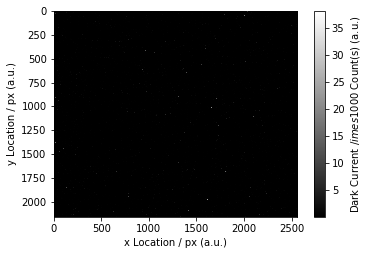

In [7]:
DC = np.empty((ndark, w, h))
for ii in range(0, len(DC)):
    DC[ii] = fits.getdata(dark[ii])[0]
    
DC_correction = np.flip(np.mean(DC, axis=0), axis=0)

fig = plt.figure(figsize=(pagewidth, 
                          pagewidth / goldenrat))
plt.imshow(DC_correction / 1000, cmap='gray')
plt.xlabel('x Location / px (a.u.)')
plt.ylabel('y Location / px (a.u.)')
plt.colorbar(label = r'Dark Current /' + 
             '$\times 1000$ Count(s) (a.u.)')

plt.savefig("Figures/DC.pdf", bbox_inches='tight')

### Open Beam Load

This is a similar operaton. The open beam data are loaded from the filesystem and the mean is once again taken for all open beam frames. The correction calculation requires a rescale factor (division-rescale operation). 

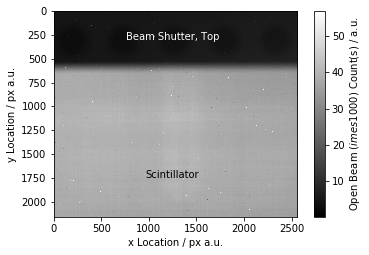

In [8]:
OB = np.empty((nopenb, w, h))
for ii in range(0, len(OB)):
    OB[ii] = fits.getdata(openb[ii])[0]
    
OB_correction = (np.flip(np.max(OB, axis=0), 
                         axis=0) - DC_correction).clip(min=1)
OB_rescale_fac = np.mean(OB_correction)

fig = plt.figure(figsize=(pagewidth, 
                          pagewidth / goldenrat))
plt.imshow(OB_correction / 1000, cmap='gray')
plt.xlabel('x Location / px a.u.')
plt.ylabel('y Location / px a.u.')
plt.text(1250, 300, "Beam Shutter, Top", 
         ha='center', 
         color='#ffffff')
plt.text(1250, 1750, "Scintillator", 
         ha='center', 
         color='#000000')
plt.colorbar(label=r'Open Beam ' +
             '($\times 1000$) Count(s) / a.u.')

plt.savefig("Figures/OB.pdf", bbox_inches='tight')

### Black Body Load

Black body images account for scatter from the mirror. These are loaded in an identical manner to all other images and a mean is calculated which accounts for noisy regions in the data which are reproducable. 

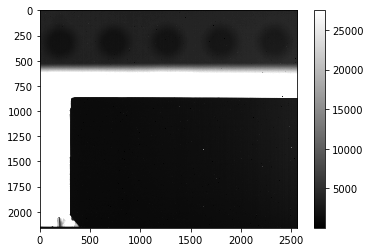

In [9]:
BB = np.empty((nblack, w, h))
for ii in range(0, len(black)):
    BB[ii] = np.flip(fits.getdata(black[ii]), 
                     axis=1)
    
BB_correction = ((np.mean(BB, 
                          axis=0)) 
                 - DC_correction).clip(min=1)

plt.imshow(BB_correction.clip(max=27500), 
           cmap='gray')
plt.colorbar()

### Dry Sample Load

The final corrections are now loaded from the filesystem. These account for the effect of the dry sample and any artefacting resulting from this. A rescale factor is also determined.

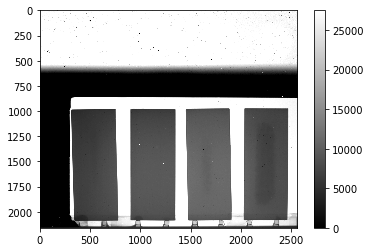

In [10]:
DRY = np.empty((ndry, w, h))
for ii in range(0, len(DRY)):
    DRY[ii] = fits.getdata(dry[ii])[0]

DRY_mean = np.flip(np.mean(DRY, axis=0), 
                   axis=0)
DRY_Correction  = ((((DRY_mean / OB_correction) 
                     * OB_rescale_fac)) 
                   - DC_correction).clip(min=1)
DRY_Correction = (DRY_Correction 
                  - BB_correction).clip(min=0)
DRY_rescale_fac = np.mean(DRY_Correction)

plt.imshow(DRY_Correction.clip(max=27500), 
           cmap='gray')
plt.colorbar()

## Raw Data Processing

Load the raw data from the filesystem into RAM, correct for the dry sample uptake as images are loaded during the loop. When correcting for dark current it must be ensured that no values appear where the matrix becomes negative because of specular noise. The corrected acquisition is clipped to a minima of 1.0. <br><br>We need to also ensure we NEVER divide by a negative or zero value. Clipping to zero results in infinity ``inf`` values in the result so these data are clipped to unity, as are corrections for dry samples and open beam data. Corrections are also carried out for the proton dose at this point.

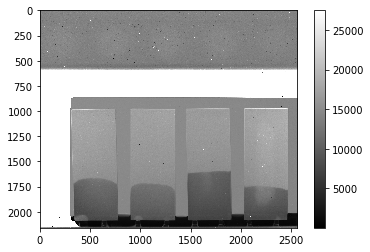

In [11]:
RAW = np.empty((nfiles, w, h))
mdry = np.mean(DRY)

for ii in range(0, len(RAW)):
    # Pull the raw data from disk
    RAW[ii] = ((np.flip(fits.getdata(files[ii])[0], axis=0) * factors[ii]) - DC_correction)
    
    RAW[ii] = (RAW[ii] / OB_correction.clip(min=1))   * OB_rescale_fac
    RAW[ii] = ((RAW[ii] / DRY_Correction.clip(min=1)) * DRY_rescale_fac)
    RAW[ii] = (RAW[ii] - BB_correction)
    RAW[ii] = RAW[ii].clip(min=1.0)
    
plt.imshow(RAW[-1].clip(max=27500), cmap='gray')
plt.colorbar()

The sample has been corrected for dark current, open beam, dry data artefacts, and back scattering. Now each sample is cropped directly from the corrected raw data. The crop dimensions may be adjusted here by changing the x and y values. Width and height ought to remain constant for the experiment.

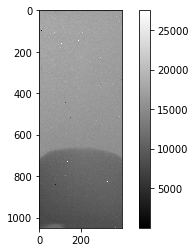

In [12]:
width  = 400
height = 1050

x = 340
y = 1000
Sample2 = np.empty((nfiles, height, width))
for ii in range(0, len(RAW)):
    Sample2[ii] = RAW[ii][y:y+height, x:x+width]

x = 900
y = 1000
Sample4 = np.empty((nfiles, height, width))
for ii in range(0, len(RAW)):
    Sample4[ii] = RAW[ii][y:y+height, x:x+width]

x = 1490
y = 1000
Sample14 = np.empty((nfiles, height, width))
for ii in range(0, len(RAW)):
    Sample14[ii] = RAW[ii][y:y+height, x:x+width]

x = 2030
y = 1000
Sample16 = np.empty((nfiles, height, width))
for ii in range(0, len(RAW)):
    Sample16[ii] = RAW[ii][y:y+height, x:x+width]
    
plt.imshow(Sample2[-1].clip(max=27500), cmap='gray')
plt.colorbar()

Front locations are now calculated. The mean grayscale value across the $y$ direction is integrated in the $x$. This is smoothed using the convolution of a Hann window across the data. The profile is rebinned.

In [13]:
s2_frontlocs  = np.empty(len(files))
s4_frontlocs  = np.empty(len(files))
s14_frontlocs = np.empty(len(files))
s16_frontlocs = np.empty(len(files))

for ii in range(0, len(files)):
    profile = smooth(np.mean(Sample2[ii].clip(max=18000), axis=1))
    s2_frontlocs[ii] = height - np.argmin(np.diff(profile))
    
    profile = smooth(np.mean(Sample4[ii].clip(max=18000), axis=1))
    s4_frontlocs[ii] = height - np.argmin(np.diff(profile))
    
    profile = smooth(np.mean(Sample14[ii].clip(max=18000), axis=1))
    s14_frontlocs[ii] = height - np.argmin(np.diff(profile))
    
    profile = smooth(np.mean(Sample16[ii].clip(max=18000), axis=1))
    s16_frontlocs[ii] = height - np.argmin(np.diff(profile))

## Step Wedge Quantification

Quantification of the moisture content of the system is carried out by calibrating images to the grayscale value produced by known quantities of water placed in front of a sample. <br><br> Load dry and wet wedges into memory. Correct for dark current, open beam, and dry samples. Rescale the corrected array and write to a text image which can be loaded to a third-party package to determine the grayscale intensity of each block.

In [14]:
dry_wedges = np.empty((len(wedges_dry), w, h))
wet_wedges = np.empty((len(wedges_wet), w, h))
corr_wedges = np.empty((len(wedges_dry), w, h))

for ii in range(0, len(wedges_dry)):
    dry_wedges[ii] = (np.flip((fits.getdata(wedges_dry[ii])[0]), axis=0) - DC_correction).clip(min=1)
    wet_wedges[ii] = (np.flip((fits.getdata(wedges_wet[ii])[0]), axis=0) - DC_correction).clip(min=1)

corr_dry_wedges = ((np.mean(dry_wedges, axis=0) / OB_correction) * OB_rescale_fac - BB_correction)
corr_wet_wedges = ((np.mean(wet_wedges, axis=0) / OB_correction) * OB_rescale_fac - BB_correction)

DRY_rescale_fac = np.mean(corr_dry_wedges)
DRY_Correction = (corr_wet_wedges / corr_dry_wedges) * DRY_rescale_fac

np.savetxt('wedges.txt', DRY_Correction.clip(max=27500)[1000:1750,1385:1550])

Grayscale intensity values are held in the `GSV` array, with upper and lower bounds in `UB` and `LB` respectively. The pixel volume is known, and the percentage equivalent of each step thickness is calculated knowing the pixel geometry. <br><br>

Two functions are defined. A linear $y = mx + c$ function and a function which returns $x$ as a function of $y$. Optimization is carried out using the `scipy.optimize` module and is applied to the mean, upper, and lower bounds of the data. There is also some visualisation in this code. The data are hard-coded and should be readjusted for other experiments.

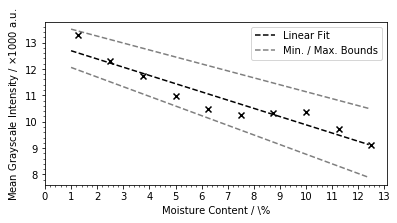

In [15]:
GSV = [13270.980, 12284.201, 11733.692, 10982.286, 10483.478, 10270.661, 10334.157, 10368.810, 9716.7920, 9117.4940]
LB  = [12635.052, 11611.407, 10904.477, 10253.253, 9177.3310, 8379.4360, 10904.687, 9278.4990, 8478.0520, 7471.5600]
UB  = [13982.405, 13090.503, 12363.196, 12548.141, 10938.053, 11501.653, 12972.963, 11156.311, 10998.677, 10035.324]

pixel_volume = pixel_size * pixel_size * 40
contents = np.arange(0.5, 5.1, 0.5) / pixel_volume

def func(m, x, c):
    return m * x + c

def invfunc(m, y, c):
    return (y - c) / m

# Mean Grayscale Value
popt, pcov = curve_fit(func, contents, GSV)
GSV_mval = popt[0]
GSV_cval = popt[1]

# Upper Bound
popt, pcov = curve_fit(func, contents, LB)
LB_mval = popt[0]
LB_cval = popt[1]

# Lower Bound
popt, pcov = curve_fit(func, contents, UB)
UB_mval = popt[0]
UB_cval = popt[1]

# Visualisation
fig = plt.figure(figsize=(pagewidth, 3))
plt.scatter(contents, np.divide(GSV,1000), marker='x', c='k')
xrange = np.arange(1, 12.5, pixel_size)

yvals = func(GSV_mval, xrange, GSV_cval)
plt.plot(xrange, yvals / 1000, c='k', ls='--', label='Linear Fit')

yvals = func(UB_mval, xrange, UB_cval)
plt.plot(xrange, yvals / 1000, c='k', ls='--', alpha=0.5, label='Min. / Max. Bounds')

yvals = func(LB_mval, xrange, LB_cval)
plt.plot(xrange, yvals / 1000, c='k', ls='--', alpha=0.5)

plt.legend()

plt.xlabel(r"Moisture Content / \%")
plt.ylabel(r"Mean Grayscale Intensity / $\times 1000$ a.u.")
plt.minorticks_on()
ticks = plt.xticks(np.arange(0, 13.1, 1))
plt.savefig("LSQFit.pdf", bbox_inches='tight')

### Final Calibration

The final calibration computes a new equivalent intensity where the intensity defined is the calibrated moisture content of the sample. This is done iteratively for the entire dataset.

In [16]:
for ii in range(0, len(Sample2)):
    Sample2[ii]  = invfunc(GSV_mval, Sample2[ii],  GSV_cval).clip(min=0)
    Sample4[ii]  = invfunc(GSV_mval, Sample4[ii],  GSV_cval).clip(min=0)
    Sample14[ii] = invfunc(GSV_mval, Sample14[ii], GSV_cval).clip(min=0)
    Sample16[ii] = invfunc(GSV_mval, Sample16[ii], GSV_cval).clip(min=0)

In [17]:
for ii in range(0, 1):
    fig = plt.figure(figsize=(10, 4))
    plt.imshow(Sample2[ii].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
    plt.colorbar()
    plt.savefig("gif/image" + str(ii) + '.jpg', bbox_inches='tight')
    plt.close(fig)

What is left is a series of three dimensional arrays which contain moisture content for each pixel. We also have a series of vectors containing the location of the front. These may then be used for visualisation.

# Moisture Content Distributions

Moisture content distributions from calibrated data...

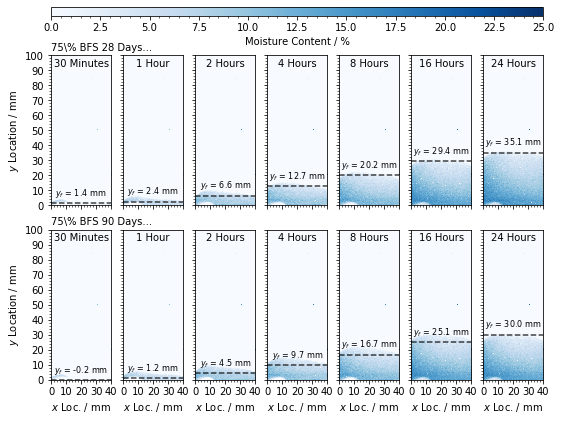

In [18]:
fig = plt.figure(figsize=(pageheight, pagewidth))
gs = plt.GridSpec(2,7)

fig.text(0.125,0.880, "75\% BFS 28 Days...")
fig.text(0.125,0.485, "75\% BFS 90 Days...")

ax0 = plt.subplot(gs[0])
ax0.imshow(Sample2[6].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
plt.ylim(0, 100)
xticks = plt.xticks(np.arange(0, 41, 10), [])
ax0.axhline(s2_frontlocs[6] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s2_frontlocs[6] * pixel_size + 5, 
        "$y_f$ = {} mm".format(np.round(s2_frontlocs[6] * pixel_size, 1)),
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "30 Minutes", ha='center', color='#000000')
plt.minorticks_on()
plt.ylabel("$y$ Location / mm")

plt.subplot(gs[1])
ax1 = plt.imshow(Sample2[12].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s2_frontlocs[12] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s2_frontlocs[12] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s2_frontlocs[12] * pixel_size, 1)),
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "1 Hour", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

plt.subplot(gs[2])
ax2 = plt.imshow(Sample2[24].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s2_frontlocs[24] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s2_frontlocs[24] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s2_frontlocs[24] * pixel_size, 1)), 
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "2 Hours", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

plt.subplot(gs[3])
ax3 = plt.imshow(Sample2[48].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s2_frontlocs[48] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s2_frontlocs[48] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s2_frontlocs[48] * pixel_size, 1)),
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "4 Hours", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

plt.subplot(gs[4])
ax4 = plt.imshow(Sample2[96].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s2_frontlocs[96] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s2_frontlocs[96] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s2_frontlocs[96] * pixel_size, 1)),
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "8 Hours", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

plt.subplot(gs[5])
ax5 = plt.imshow(Sample2[192].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s2_frontlocs[192] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s2_frontlocs[192] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s2_frontlocs[192] * pixel_size, 1)),
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "16 Hours", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

ax6 = plt.subplot(gs[6])
ax6.imshow(Sample2[-1].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s2_frontlocs[-1] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s2_frontlocs[-1] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s2_frontlocs[-1] * pixel_size, 1)),
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "24 Hours", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

## LOWER PLOT

ax7 = plt.subplot(gs[7])
ax7.imshow(Sample2[6].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
ax7.set_ylim(0, 100)
xticks = plt.xticks(np.arange(0, 41, 10))
ax7.axhline(s4_frontlocs[6] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax7.text(20, s4_frontlocs[6] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s4_frontlocs[6] * pixel_size, 1)),
         color='#000000', ha='center', fontsize=8)
ax7.text(20, 92.5, "30 Minutes", ha='center', color='#000000')
ax7.minorticks_on()
ax7.set_ylabel("$y$ Location / mm")
ax7.set_xlabel("$x$ Loc. / mm")

ax8 = plt.subplot(gs[8])
ax8.imshow(Sample2[12].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax8.axhline(s4_frontlocs[12] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax8.text(20, s4_frontlocs[12] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s4_frontlocs[12] * pixel_size, 1)),
         color='#000000', ha='center', fontsize=8)
ax8.text(20, 92.5, "1 Hour", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax8.set_xlabel("$x$ Loc. / mm")

ax9 = plt.subplot(gs[9])
ax9.imshow(Sample2[24].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax9.axhline(s4_frontlocs[24] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax9.text(20, s4_frontlocs[24] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s4_frontlocs[24] * pixel_size, 1)),
         color='#000000', ha='center', fontsize=8)
ax9.text(20, 92.5, "2 Hours", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax9.set_xlabel("$x$ Loc. / mm")

ax10 = plt.subplot(gs[10])
ax10.imshow(Sample2[48].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax10.axhline(s4_frontlocs[48] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax10.text(20, s4_frontlocs[48] * pixel_size + 5, 
          "$y_f$ = {} mm".format(np.round(s4_frontlocs[48] * pixel_size, 1)),
          color='#000000', ha='center', fontsize=8)
ax10.text(20, 92.5, "4 Hours", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax10.set_xlabel("$x$ Loc. / mm")

ax11 = plt.subplot(gs[11])
ax11.imshow(Sample2[96].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax11.axhline(s4_frontlocs[96] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax11.text(20, s4_frontlocs[96] * pixel_size + 5, 
          "$y_f$ = " + str(s4_frontlocs[96] * pixel_size)[0:4] + " mm", 
          color='#000000', ha='center', fontsize=8)
ax11.text(20, 92.5, "8 Hours", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax11.set_xlabel("$x$ Loc. / mm")

ax12 = plt.subplot(gs[12])
ax12.imshow(Sample2[192].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax12.axhline(s4_frontlocs[192] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax12.text(20, s4_frontlocs[192] * pixel_size + 5, 
          "$y_f$ = {} mm".format(np.round(s4_frontlocs[192] * pixel_size, 1)),
          color='#000000', ha='center', fontsize=8)
ax12.text(20, 92.5, "16 Hours", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax12.set_xlabel("$x$ Loc. / mm")

ax13 = plt.subplot(gs[13])
ax13.imshow(Sample2[192].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax13.axhline(s4_frontlocs[-1] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax13.text(20, s4_frontlocs[-1] * pixel_size + 5, 
          "$y_f$ = {} mm".format(np.round(s4_frontlocs[-1] * pixel_size, 1)),
          color='#000000', ha='center', fontsize=8)
ax13.text(20, 92.5, "24 Hours", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax13.set_xlabel("$x$ Loc. / mm")

cbaxes = fig.add_axes([0.125, 0.96, 0.775, 0.02]) 
cb = plt.colorbar(ax1, cax = cbaxes, orientation="horizontal", label=r'Moisture Content / %')
cb.ax.minorticks_on()
cb.set_ticks(np.arange(0, 42.5, 2.5))

plt.subplots_adjust(hspace=pixel_size)
plt.savefig("75pctQuantifiedNR.pdf", bbox_inches='tight')

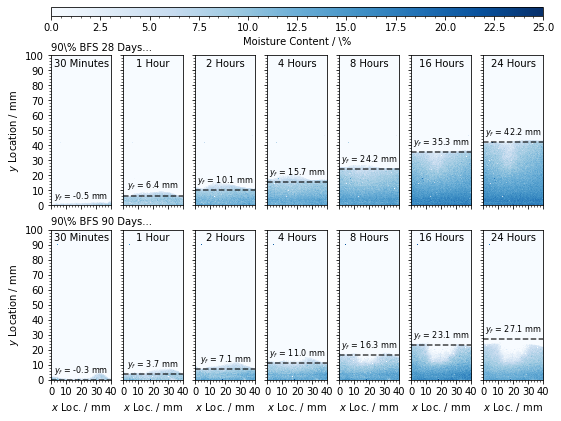

In [19]:
fig = plt.figure(figsize=(pageheight, pagewidth))
gs = plt.GridSpec(2,7)

fig.text(0.125,0.880, "90\% BFS 28 Days...")
fig.text(0.125,0.485, "90\% BFS 90 Days...")

ax0 = plt.subplot(gs[0])
ax0.imshow(Sample14[6].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
plt.ylim(0, 100)
xticks = plt.xticks(np.arange(0, 41, 10), [])
ax0.axhline(s14_frontlocs[6] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s14_frontlocs[6] * pixel_size + 5,
         "$y_f$ = {} mm".format(np.round(s14_frontlocs[6] * pixel_size, 1)), 
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "30 Minutes", ha='center', color='#000000')
plt.minorticks_on()
plt.ylabel("$y$ Location / mm")

plt.subplot(gs[1])
ax1 = plt.imshow(Sample14[12].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s14_frontlocs[12] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s14_frontlocs[12] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s14_frontlocs[12] * pixel_size, 1)), 
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "1 Hour", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

plt.subplot(gs[2])
ax2 = plt.imshow(Sample14[24].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s14_frontlocs[24] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s14_frontlocs[24] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s14_frontlocs[24] * pixel_size, 1)), 
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "2 Hours", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

plt.subplot(gs[3])
ax3 = plt.imshow(Sample14[48].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s14_frontlocs[48] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s14_frontlocs[48] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s14_frontlocs[48] * pixel_size, 1)), 
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "4 Hours", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

plt.subplot(gs[4])
ax4 = plt.imshow(Sample14[96].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s14_frontlocs[96] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s14_frontlocs[96] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s14_frontlocs[96] * pixel_size, 1)), 
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "8 Hours", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

plt.subplot(gs[5])
ax5 = plt.imshow(Sample14[192].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s14_frontlocs[192] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s14_frontlocs[192] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s14_frontlocs[192] * pixel_size, 1)), 
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "16 Hours", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

ax6 = plt.subplot(gs[6])
ax6.imshow(Sample14[-1].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
plt.axhline(s14_frontlocs[-1] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
plt.text(20, s14_frontlocs[-1] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s14_frontlocs[-1] * pixel_size, 1)), 
         color='#000000', ha='center', fontsize=8)
plt.text(20, 92.5, "24 Hours", ha='center', color='#000000')
yticks = plt.yticks(np.arange(0, 101, 10), [])
xticks = plt.xticks(np.arange(0, 41, 10), [])
plt.minorticks_on()

## LOWER PLOT

ax7 = plt.subplot(gs[7])
ax7.imshow(Sample16[6].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
ax7.set_ylim(0, 100)
xticks = plt.xticks(np.arange(0, 41, 10))
ax7.axhline(s16_frontlocs[6] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax7.text(20, s16_frontlocs[6] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s16_frontlocs[6] * pixel_size, 1)), 
         color='#000000', ha='center', fontsize=8)
ax7.text(20, 92.5, "30 Minutes", ha='center', color='#000000')
ax7.minorticks_on()
ax7.set_ylabel("$y$ Location / mm")
ax7.set_xlabel("$x$ Loc. / mm")

ax8 = plt.subplot(gs[8])
ax8.imshow(Sample16[12].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax8.axhline(s16_frontlocs[12] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax8.text(20, s16_frontlocs[12] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s16_frontlocs[12] * pixel_size, 1)), 
         color='#000000', ha='center', fontsize=8)
ax8.text(20, 92.5, "1 Hour", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax8.set_xlabel("$x$ Loc. / mm")

ax9 = plt.subplot(gs[9])
ax9.imshow(Sample16[24].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax9.axhline(s16_frontlocs[24] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax9.text(20, s16_frontlocs[24] * pixel_size + 5, 
         "$y_f$ = {} mm".format(np.round(s16_frontlocs[24] * pixel_size, 1)), 
         color='#000000', ha='center', fontsize=8)
ax9.text(20, 92.5, "2 Hours", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax9.set_xlabel("$x$ Loc. / mm")

ax10 = plt.subplot(gs[10])
ax10.imshow(Sample16[48].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax10.axhline(s16_frontlocs[48] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax10.text(20, s16_frontlocs[48] * pixel_size + 5, 
          "$y_f$ = {} mm".format(np.round(s16_frontlocs[48] * pixel_size, 1)), 
          color='#000000', ha='center', fontsize=8)
ax10.text(20, 92.5, "4 Hours", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax10.set_xlabel("$x$ Loc. / mm")

ax11 = plt.subplot(gs[11])
ax11.imshow(Sample16[96].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax11.axhline(s16_frontlocs[96] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax11.text(20, s16_frontlocs[96] * pixel_size + 5, 
          "$y_f$ = {} mm".format(np.round(s16_frontlocs[96] * pixel_size, 1)), 
          color='#000000', ha='center', fontsize=8)
ax11.text(20, 92.5, "8 Hours", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax11.set_xlabel("$x$ Loc. / mm")

ax12 = plt.subplot(gs[12])
ax12.imshow(Sample16[192].clip(max=25), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax12.axhline(s16_frontlocs[192] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax12.text(20, s16_frontlocs[192] * pixel_size + 5, 
          "$y_f$ = {} mm".format(np.round(s16_frontlocs[192] * pixel_size, 1)), 
          color='#000000', ha='center', fontsize=8)
ax12.text(20, 92.5, "16 Hours", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax12.set_xlabel("$x$ Loc. / mm")

ax13 = plt.subplot(gs[13])
ax13.imshow(Sample16[192].clip(max=30), cmap=cmap, extent=(0, 40, 0, 100))
yticks = plt.yticks(np.arange(0, 101, 10))
xticks = plt.xticks(np.arange(0, 41, 10))
ax13.axhline(s16_frontlocs[-1] * pixel_size, 0, 1, ls='--', c='#000000', alpha=0.75)
ax13.text(20, s16_frontlocs[-1] * pixel_size + 5, 
          "$y_f$ = {} mm".format(np.round(s16_frontlocs[-1] * pixel_size, 1)), 
          color='#000000', ha='center', fontsize=8)
ax13.text(20, 92.5, "24 Hours", ha='center', color='#000000')
plt.minorticks_on()
plt.yticks(np.arange(0, 101, 10), [])
ax13.set_xlabel("$x$ Loc. / mm")

cbaxes = fig.add_axes([0.125, 0.96, 0.775, 0.02]) 
cb = plt.colorbar(ax1, cax = cbaxes, orientation="horizontal", label="Moisture Content / \%")
cb.ax.minorticks_on()
cb.set_ticks(np.arange(0, 42.5, 2.5))

plt.subplots_adjust(hspace=pixel_size)
plt.savefig("90pctQuantifiedNR.pdf", bbox_inches='tight')

# Front Location Plot

Plot the location of the front with time...

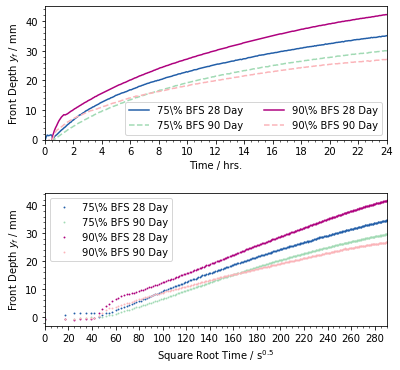

In [20]:
fig = plt.figure(figsize=(pagewidth, pageheight / 1.5))

gs = plt.GridSpec(2, 1)

ax0 = plt.subplot(gs[0])
ax0.plot(times / 3600, s2_frontlocs * pixel_size, c='#225ea8', label='75\% BFS 28 Day')
ax0.plot(times / 3600, s4_frontlocs * pixel_size, c='#a1dab4', ls='--', label='75\% BFS 90 Day')

ax0.plot(times / 3600, s14_frontlocs * pixel_size, c='#ae017e', label='90\% BFS 28 Day')
ax0.plot(times / 3600, s16_frontlocs * pixel_size, c='#fbb4b9', ls='--', label='90\% BFS 90 Day')

ax0.set_xlim(0, 24)
ax0.set_ylim(0, 45)

ax0.set_xticks(np.arange(0, 24.1, 2))

ax0.set_xlabel("Time / hrs.")
ax0.set_ylabel("Front Depth $y_f$ / mm")
ax0.legend(ncol=2)
ax0.minorticks_on()

ax1 = plt.subplot(gs[1])
ax1.scatter(np.sqrt(times), s2_frontlocs * pixel_size, c='#225ea8', label='75\% BFS 28 Day', marker='o', s=0.8)
ax1.scatter(np.sqrt(times), s4_frontlocs * pixel_size, c='#a1dab4', label='75\% BFS 90 Day', marker='o', s=0.8)

ax1.scatter(np.sqrt(times), s14_frontlocs * pixel_size, c='#ae017e', label='90\% BFS 28 Day', marker='o', s=0.8)
ax1.scatter(np.sqrt(times), s16_frontlocs * pixel_size, c='#fbb4b9', label='90\% BFS 90 Day', marker='o', s=0.8)

#ax1.scatter(-1, 0, c='#225ea8', label='75\% BFS 28 Day', marker='o', s=0.8)
#ax1.scatter(-1, 0, c='#a1dab4', label='75\% BFS 90 Day', marker='o', s=0.8)
#ax1.scatter(-1, 0, c='#ae017e', label='90\% BFS 28 Day', marker='o', s=0.8)
#ax1.scatter(-1, 0, c='#fbb4b9', label='90\% BFS 90 Day', marker='o', s=0.8)


ax1.set_xlim(0, 290)
ax1.set_xticks(np.arange(0, 290, 20))
ax1.minorticks_on()
ax1.set_xlabel("Square Root Time / s$^{0.5}$")
ax1.set_ylabel("Front Depth $y_f$ / mm")
ax1.legend()

plt.subplots_adjust(hspace=0.4)

plt.savefig("Uptake_Plot.pdf", bbox_inches='tight')


# Histograms From Disk

In [21]:
s2_histogram  = np.genfromtxt("Histogram_s2.txt")
s4_histogram  = np.genfromtxt("Histogram_s4.txt")
s14_histogram = np.genfromtxt("Histogram_s14.txt")
s16_histogram = np.genfromtxt("Histogram_s16.txt")

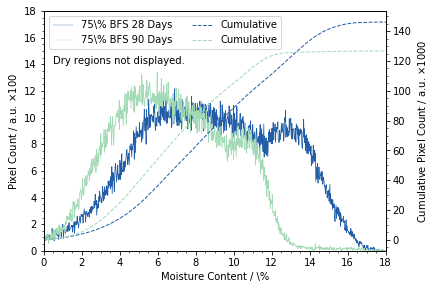

In [22]:
fig = plt.figure(figsize=(pagewidth, pageheight / 2))
plt.plot(s2_histogram[1:,0], s2_histogram[1:,1] * 0.04, label='75\% BFS 28 Days', c='#225ea8', lw=0.75)
plt.plot(s4_histogram[1:,0], s4_histogram[1:,1] * 0.04, label='75\% BFS 90 Days', c='#a1dab4', lw=0.75)
plt.xlabel("Moisture Content / \%")
plt.ylabel(r"Pixel Count / a.u. $\times$100")
plt.ylim(0, 18)
plt.minorticks_on()
plt.text(0.5, 14, "Dry regions not displayed.")

plt.twinx()
plt.plot(0, 0, label='75\% BFS 28 Days', c='#225ea8', lw=0.33)
plt.plot(0, 0, label='75\% BFS 90 Days', c='#a1dab4', lw=0.33)
plt.plot(s2_histogram[1:,0], np.cumsum(s2_histogram[1:,1]) / 1000, label='Cumulative', c='#225ea8', lw=1, ls='--')
plt.plot(s4_histogram[1:,0], np.cumsum(s4_histogram[1:,1]) / 1000, label='Cumulative', c='#a1dab4', lw=1, ls='--')
#plt.ylim(0, 6)
plt.minorticks_on()
plt.legend(loc=2, ncol=2)

plt.ylabel(r"Cumulative Pixel Count / a.u. $\times 1000$")
plt.xlim(0, 18)
plt.savefig("75pctHistogram.pdf", bbox_inches='tight')

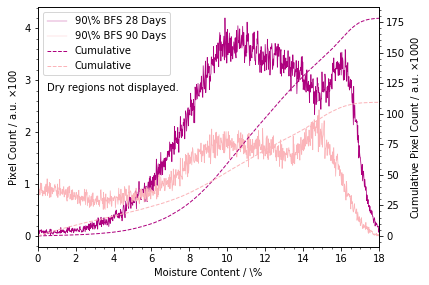

In [23]:
fig = plt.figure(figsize=(pagewidth, pageheight / 2))
plt.plot(s14_histogram[1:,0],  s14_histogram[1:,1] / 100, label='90\% BFS 28 Days', c='#ae017e', lw=0.75)
plt.plot(s16_histogram[1:,0], s16_histogram[1:,1] / 100, label='90\% BFS 90 Days', c='#fbb4b9', lw=0.75)
plt.xlabel("Moisture Content / \%")
plt.ylabel(r"Pixel Count / a.u. $\times$100")
plt.minorticks_on()
plt.text(0.5, 2.8, "Dry regions not displayed.")

plt.twinx()
plt.plot(0, 0, label='90\% BFS 28 Days', c='#ae017e', lw=0.33)
plt.plot(0, 0, label='90\% BFS 90 Days', c='#fbb4b9', lw=0.33)
plt.plot(s14_histogram[1:,0],  np.cumsum(s14_histogram[1:,1]) / 1000, label='Cumulative', c='#ae017e', lw=1, ls='--')
plt.plot(s16_histogram[1:,0], np.cumsum(s16_histogram[1:,1]) / 1000, label='Cumulative', c='#fbb4b9', lw=1, ls='--')
plt.minorticks_on()
plt.legend(loc=2, ncol=1)

plt.xlim(0, 18)

plt.ylabel(r"Cumulative Pixel Count / a.u. $\times 1000$")
plt.savefig("90pctHistogram.pdf")

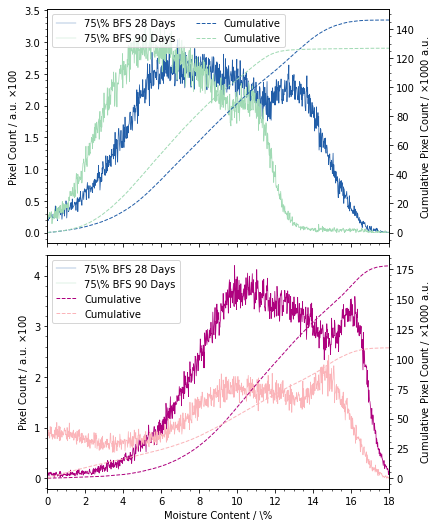

In [24]:
fig = plt.figure(figsize=(pagewidth, pageheight))
gs = plt.GridSpec(2,1)

ax0 = plt.subplot(gs[0])
ax0.plot(s2_histogram[1:,0], s2_histogram[1:,1] / 100, label='75\% BFS 28 Days', c='#225ea8', lw=0.75)
ax0.plot(s4_histogram[1:,0], s4_histogram[1:,1] / 100, label='75\% BFS 90 Days', c='#a1dab4', lw=0.75)
ax0.set_xlim(0, 18)
ax0.set_ylabel(r"Pixel Count / a.u. $\times$100")
ax1 = ax0.twinx()
ax1.plot(0, 0, label='75\% BFS 28 Days', c='#225ea8', lw=0.33)
ax1.plot(0, 0, label='75\% BFS 90 Days', c='#a1dab4', lw=0.33)
ax1.plot(s2_histogram[1:,0], np.cumsum(s2_histogram[1:,1]) / 1000, label='Cumulative', c='#225ea8', lw=1, ls='--')
ax1.plot(s4_histogram[1:,0], np.cumsum(s4_histogram[1:,1]) / 1000, label='Cumulative', c='#a1dab4', lw=1, ls='--')
ax1.legend(loc=2, ncol=2)
ax1.set_xticklabels([])
ax0.minorticks_on()
ax1.minorticks_on()

ax2 = plt.subplot(gs[1])
ax2.plot(s14_histogram[1:,0], s14_histogram[1:,1] / 100, label='75\% BFS 28 Days', c='#ae017e', lw=0.75)
ax2.plot(s16_histogram[1:,0], s16_histogram[1:,1] / 100, label='75\% BFS 90 Days', c='#fbb4b9', lw=0.75)
ax2.set_xlim(0, 18)
ax2.set_ylabel(r"Pixel Count / a.u. $\times$100")
ax3 = ax2.twinx()
ax3.plot(0, 0, label='75\% BFS 28 Days', c='#225ea8', lw=0.33)
ax3.plot(0, 0, label='75\% BFS 90 Days', c='#a1dab4', lw=0.33)
ax3.plot(s14_histogram[1:,0], np.cumsum(s14_histogram[1:,1]) / 1000, label='Cumulative', c='#ae017e', lw=1, ls='--')
ax3.plot(s16_histogram[1:,0], np.cumsum(s16_histogram[1:,1]) / 1000, label='Cumulative', c='#fbb4b9', lw=1, ls='--')
ax3.legend(loc=2, ncol=1)
ax2.minorticks_on()
ax3.minorticks_on()

ax1.set_ylabel(r"Cumulative Pixel Count / $\times 1000$ a.u.")
ax2.set_xlabel(r"Moisture Content / \%")
ax3.set_ylabel(r"Cumulative Pixel Count / $\times 1000$ a.u.")

plt.subplots_adjust(hspace=0.05)

plt.savefig("MoistureContentDistribution.pdf", bbox_inches='tight')

# Determine the Sample Porosity

We have the number of pixels. The total volume of water is the volume of every pixel multiplied by the moisture content of each pixel.

In [25]:
volume = (np.count_nonzero(Sample2[-1])) * pixel_size * pixel_size * 40 # Volume in mm3 by non-zero pixels.
volume_front = s2_frontlocs[-1]          * pixel_size * 40  * 40 # Bulk Volume as by the front depth

print("Porous Volume: " + str(volume / 1000)[:4] + "cm3")
fit = (volume_front / volume) * 100
print("Volume calculation lies within " + str(fit) + " % of the geometric ideal of the front.")

nonzero_indices = np.nonzero(Sample2[-1]) # Returns array indices of the non-zero values
vw = np.sum((Sample2[-1][nonzero_indices] / 100) * pixel_size * pixel_size * 40) / 1000 # Volume of water

print("Porosity is: " + str(np.mean(Sample2[-1][nonzero_indices] / 100) * 100)[:4] + " %")
print("Standard Dev: " + str(np.std(Sample2[-1][nonzero_indices]))[:4])

Porous Volume: 58.4cm3
Volume calculation lies within 96.09461623752617 % of the geometric ideal of the front.
Porosity is: 9.07 %
Standard Dev: 3.85


In [26]:
volume = (np.count_nonzero(Sample4[-1])) * pixel_size * pixel_size * 40 # Volume in mm3 by non-zero pixels.
volume_front = s4_frontlocs[-1]          * pixel_size * 40  * 40 # Bulk Volume as by the front depth

print("Porous Volume: " + str(volume / 1000)[:4] + "cm3")
fit = (volume_front / volume) * 100
print("Volume calculation lies within " + str(fit)[:5] + "% of the geometric ideal of the front.")

nonzero_indices = np.nonzero(Sample4[-1]) # Returns array indices of the non-zero values
vw = np.sum((Sample4[-1][nonzero_indices] / 100) * pixel_size * pixel_size * 40) / 1000 # Volume of water

print("Porosity is: " + str(np.mean(Sample4[-1][nonzero_indices] / 100) * 100)[:4] + "%")
print("Standard Dev: " + str(np.std(Sample4[-1][nonzero_indices]))[:4])

Porous Volume: 50.6cm3
Volume calculation lies within 94.79% of the geometric ideal of the front.
Porosity is: 6.81%
Standard Dev: 3.13


In [27]:
volume = (np.count_nonzero(Sample14[-1])) * pixel_size * pixel_size * 40 # Volume in mm3 by non-zero pixels.
volume_front = s14_frontlocs[-1]          * pixel_size * 40  * 40 # Bulk Volume as by the front depth

print("Bulk Volume: " + str(volume / 1000)[:4] + " cm3")
fit = (volume_front / volume) * 100
print("Bulk Volume calculation lies within " + str(fit)[:5] + "% of the geometric ideal volume below the front.")

nonzero_indices = np.nonzero(Sample14[-1]) # Returns array indices of the non-zero values
vw = np.sum((Sample14[-1][nonzero_indices] / 100) * pixel_size * pixel_size * 40) / 1000 # Volume of water

print("Porosity is: " + str(np.mean(Sample14[-1][nonzero_indices]))[:4] + "%")
print("Standard Dev: " + str(np.std(Sample14[-1][nonzero_indices]))[:4])

Bulk Volume: 71.2 cm3
Bulk Volume calculation lies within 94.72% of the geometric ideal volume below the front.
Porosity is: 11.6%
Standard Dev: 3.51


In [28]:
volume = (np.count_nonzero(Sample16[-1])) * pixel_size * pixel_size * 40 # Volume in mm3 by non-zero pixels.
volume_front = s16_frontlocs[-1]          * pixel_size * 40  * 40 # Bulk Volume as by the front depth

print("Bulk Volume: " + str(volume / 1000)[:4] + "cm3")
fit = (volume_front / volume) * 100
print("Volume calculation lies within " + str(fit)[:5] + "% of the geometric ideal of the front.")

nonzero_indices = np.nonzero(Sample16[-1]) # Returns array indices of the non-zero values
vw = np.sum((Sample16[-1][nonzero_indices] / 100) * pixel_size * pixel_size * 40) / 1000 # Volume of water

print("Porosity is: " + str(np.mean(Sample16[-1][nonzero_indices] / 100) * 100)[:4] + "%")
print("Standard Dev: " + str(np.std(Sample16[-1][nonzero_indices]))[:4])

Bulk Volume: 43.8cm3
Volume calculation lies within 98.91% of the geometric ideal of the front.
Porosity is: 9.92%
Standard Dev: 4.63
